## 完整实现NN

[神经网络](https://zhuanlan.zhihu.com/p/450894854)

## 主函数 & 代价函数

In [1]:
import numpy as np
import scipy.io as spio
import matplotlib.pyplot as plt
from scipy import optimize
import time

datafile = '../resource/lawLite19/NeuralNetwok/data_digits.mat'

def NeuralNteworks(input_layer_size,hidden_layer_size,output_layer_size):
    data_img = spio.loadmat(datafile)
    X = data_img['X']
    Y = data_img['y']

    m,n = X.shape

    rand_indices = [t for t in [np.random.randint(x-x,m) for x in range(1000)]]
    plot_data(X[rand_indices,:])

    Lambda = 1

    init_theta_1 = randInitWeights(input_layer_size,hidden_layer_size)
    init_theta_2 = randInitWeights(hidden_layer_size,output_layer_size)

    init_nn_params = np.vstack((init_theta_1.reshape(-1,1),init_theta_2.reshape(-1,1)))

    start = time.time()
    result = optimize.fmin_cg(nnCostFunction,init_nn_params,fprime=nnGradient,args=(input_layer_size,hidden_layer_size,output_layer_size,X,Y,Lambda),maxiter=100)
    print('run time:',time.time()-start)
    print(result)

    length = result.shape[0]
    theta_1 = result[0:hidden_layer_size*(input_layer_size+1)].reshape(hidden_layer_size,input_layer_size+1)
    theta_2 = result[hidden_layer_size*(input_layer_size+1):length].reshape(output_layer_size,hidden_layer_size+1)
    plot_data(theta_1[:,1:length])
    plot_data(theta_2[:,1:length])

    p = predict(theta_1,theta_2,X)
    print('accuracy:{:.2f}%'.format(np.mean(np.float64(p == Y.reshape(-1,1))*100)))

    res = np.hstack((p.reshape(-1,1)))
    np.savetxt('predict.txt',res,delimiter=',')

def nnCostFunction(nn_params,input_layer_size,hidden_layer_size,num_labels,X,y,Lambda):
    length = nn_params.shape[0]
    theta_1 = nn_params[0:hidden_layer_size*(input_layer_size+1)].reshape(hidden_layer_size,input_layer_size+1)
    theta_2 = nn_params[hidden_layer_size*(input_layer_size+1):length].reshape(num_labels,hidden_layer_size+1)

    m = X.shape[0]
    class_y = np.zeros((m,num_labels))

    for i in range(num_labels):
        class_y[:,i] = np.int32(y==i).reshape(1,-1)

    theta1_col = theta_1.shape[1]
    theta1_x = theta_1[:,1:theta1_col]
    theta2_col = theta_2.shape[1]
    theta2_x = theta_2[:,1:theta2_col]

    temp = np.dot(np.transpose(np.vstack((theta1_x.reshape(-1,1),theta2_x.reshape(-1,1)))),np.vstack((theta1_x.reshape(-1,1),theta2_x.reshape(-1,1))))

    a1 = np.hstack((np.ones((m,1)),X))
    z2 = np.dot(a1,np.transpose(theta_1))
    a2 = sigmoid(z2)
    a2 = np.hstack((np.ones((m,1)),a2))
    z3 = np.dot(a2,np.transpose(theta_2))
    h = sigmoid(z3)

    J = -(np.dot(np.transpose(class_y.reshape(-1,1)),np.log(h.reshape(-1,1)))+np.dot(np.transpose(1-class_y.reshape(-1,1)),np.log(1-h.reshape(-1,1))))/m + temp*Lambda/2/m

    return np.ravel(J)

Duplicate key in file PosixPath('/Users/alphajay/.virtualenvs/ml/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc'), line 405 ('axes.unicode_minus: True  # use Unicode for the minus symbol rather than hyphen.  See')


## 反向传播梯度

In [3]:
def nnGradient(nn_params,input_layer_size,hidden_layer_size,num_labels,X,y,Lambda):
    length = nn_params.shape[0]

    theta_1 = nn_params[0:hidden_layer_size*(input_layer_size+1)].reshape(hidden_layer_size,input_layer_size+1).copy()
    theta_2 = nn_params[hidden_layer_size*(input_layer_size+1):length].reshape(num_labels,hidden_layer_size+1).copy()

    m = X.shape[0]
    class_y = np.zeros((m,num_labels))

    for i in range(num_labels):
        class_y[:,i] = np.int32(y==i).reshape(1,-1)

    theta1_col = theta_1.shape[1]
    theta1_x = theta_1[:,1:theta1_col]
    theta2_col = theta_2.shape[1]
    theta2_x = theta_2[:,1:theta2_col]

    theta1_grad = np.zeros((theta_1.shape))
    theta2_grad = np.zeros((theta_2.shape))

    a1 = np.hstack((np.ones((m,1)),X))
    z2 = np.dot(a1,np.transpose(theta_1))
    a2 = sigmoid(z2)
    a2 = np.hstack((np.ones((m,1)),a2))
    z3 = np.dot(a2,np.transpose(theta_2))
    h = sigmoid(z3)

    delta_3 = np.zeros((m,num_labels))
    delta_2 = np.zeros((m,hidden_layer_size))
    for i in range(m):
        delta_3[i,:] = h[i,:] - class_y[i,:]
        theta2_grad += np.dot(np.transpose(delta_3[i,:].reshape(1,-1)),a2[i,:].reshape(1,-1))
        delta_2[i,:] = np.dot(delta_3[i,:].reshape(1,-1),theta2_x)*sigmoidGradient(z2[i,:])
        theta1_grad += np.dot(np.transpose(delta_2[i,:].reshape(1,-1)),a1[i,:].reshape(1,-1))

    theta_1[:,0] = 0
    theta_2[:,0] = 0

    grad = (np.vstack((theta1_grad.reshape(-1,1),theta2_grad.reshape(-1,1)))+Lambda*np.vstack((theta_1.reshape(-1,1),theta_2.reshape(-1,1))))/m
    return np.ravel(grad)

## 辅助函数的实现

In [4]:
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def sigmoidGradient(z):
    return sigmoid(z)*(1-sigmoid(z))

def randInitWeights(L_in,L_out):
    w = np.zeros((L_out,L_in+1))
    init_epsilon = (6.0/(L_out+L_in))**0.5
    w = np.random.rand(L_out,1+L_in)*2*init_epsilon - init_epsilon
    return w

def checkGradient(Lambda=0):
    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5
    init_theta_1 = debugInitWeights(input_layer_size,hidden_layer_size)
    init_theta_2 = debugInitWeights(hidden_layer_size,num_labels)
    X = debugInitWeights(input_layer_size-1,m)
    y = np.transpose(np.mod(np.arange(1,m+1),num_labels))

    y = y.reshape(-1,1)
    nn_params = np.vstack((init_theta_1.reshape(-1,1),init_theta_2.reshape(-1,1)))
    bp_grad = nnGradient(nn_params,input_layer_size,hidden_layer_size,num_labels,X,y,Lambda)

    num_grad = np.zeros((nn_params.shape[0]))
    step = np.zeros((nn_params.shape[0]))

    error = 1e-4
    for i in range(nn_params.shape[0]):
        step[i] = error
        loss_1 = nnCostFunction(nn_params-step.reshape(-1,1),input_layer_size,hidden_layer_size,num_labels,X,y,Lambda)
        loss_2 = nnCostFunction(nn_params+step.reshape(-1,1),input_layer_size,hidden_layer_size,num_labels,X,y,Lambda)
        num_grad[i] = (loss_2-loss_1)/(2*error)
        step[i] = 0
    res = np.hstack((num_grad.reshape(-1,1),bp_grad.reshape(-1,1)))
    print(res)

def debugInitWeights(fan_in,fan_out):
    w = np.zeros((fan_out,fan_in+1))
    x = np.arange(1,fan_out*(fan_in+1)+1)
    w = np.sin(x).reshape(w.shape)/10
    return w

## 绘图函数与预测函数

In [5]:
def plot_data(ImgData):
    sum = 0
    m,n = ImgData.shape
    width = np.int32(np.round(np.sqrt(n)))
    height = np.int32(n/width)

    rows = np.int32(np.floor(np.sqrt(m)))
    cols = np.int32(np.ceil(m/rows))

    pad = 1
    display_array = -np.ones((pad+rows*(height+pad),pad+cols*(width+pad)))
    for i in range(rows):
        for j in range(cols):
            if sum >= m:
                break
            display_array[pad+i*(height+pad):pad+i*(height+pad)+height,pad+j*(width+pad):pad+j*(width+pad)+width] = ImgData[sum,:].reshape(height,width,order='F')
            sum += 1
        if sum >= m:
            break
    plt.imshow(display_array,cmap='gray')
    plt.axis('off')
    plt.show()

def predict(theta_1,theta_2,X):
    m = X.shape[0]
    num_labels = theta_2.shape[0]

    X = np.hstack((np.ones((m,1)),X))
    h1 = sigmoid(np.dot(X,np.transpose(theta_1)))
    h1 = np.hstack((np.ones((m,1)),h1))
    h2 = sigmoid(np.dot(h1,np.transpose(theta_2)))

    p = np.array(np.where(h2[0,:]==np.max(h2,axis=1)[0]))
    for i in np.arange(1,m):
        t = np.array(np.where(h2[i,:]==np.max(h2,axis=1)[i]))
        p = np.vstack((p,t))
    return p

## run

[[ 1.23162247e-02  1.23162247e-02]
 [ 1.73828185e-04  1.73828184e-04]
 [ 2.61455142e-04  2.61455144e-04]
 [ 1.08701450e-04  1.08701450e-04]
 [ 3.92471368e-03  3.92471369e-03]
 [ 1.90101255e-04  1.90101252e-04]
 [ 2.22272329e-04  2.22272331e-04]
 [ 5.00872543e-05  5.00872547e-05]
 [-8.08459406e-03 -8.08459407e-03]
 [ 3.13170601e-05  3.13170587e-05]
 [-2.17840368e-05 -2.17840341e-05]
 [-5.48569856e-05 -5.48569864e-05]
 [-1.26669105e-02 -1.26669105e-02]
 [-1.56130211e-04 -1.56130210e-04]
 [-2.45506164e-04 -2.45506163e-04]
 [-1.09164879e-04 -1.09164881e-04]
 [-5.59342546e-03 -5.59342547e-03]
 [-2.00036570e-04 -2.00036572e-04]
 [-2.43630223e-04 -2.43630220e-04]
 [-6.32313690e-05 -6.32313673e-05]
 [ 3.09347722e-01  3.09347722e-01]
 [ 1.61067138e-01  1.61067138e-01]
 [ 1.47036522e-01  1.47036522e-01]
 [ 1.58268577e-01  1.58268577e-01]
 [ 1.57616707e-01  1.57616707e-01]
 [ 1.47236360e-01  1.47236360e-01]
 [ 1.08133003e-01  1.08133003e-01]
 [ 5.61633717e-02  5.61633717e-02]
 [ 5.19510542e-02  5

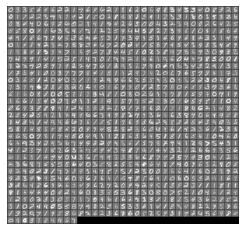

         Current function value: 0.355879
         Iterations: 100
         Function evaluations: 222
         Gradient evaluations: 222
run time: 90.56904006004333
[ 0.52414371 -0.04104413  0.02318988 ... -3.43126204 -1.76234164
  1.37555943]


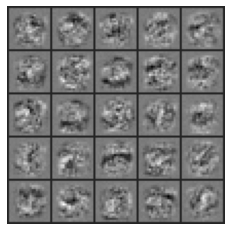

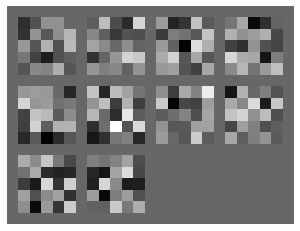

accuracy:98.50%


In [6]:
   checkGradient()
   NeuralNteworks(400,25,10)